In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain_openai langchain_experimental bs4 lxml BeatifulSoup

In [2]:
import os
import chromadb
from langchain_openai.chat_models import ChatOpenAI
import functools
from langgraph.graph import END, StateGraph, START
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage 
from typing import Annotated, List


os.environ["OPENAI_API_KEY"] = "bla"
#os.environ["PERSIST_DIRECTORY"] = "data"
#os.environ["COLLECTION_NAME"] = "gdp"

In [3]:
from multi_agent import vector_store_init, create_agent, chromadb_search, query_on_google, agent_node, create_team_supervisor, ResearchTeamState, write_document, edit_document, read_document, create_outline, read_document, prelude, DocWritingState, State, get_last_message, join_graph 

In [4]:
vector_store_init(persist_directory = "data",
                        collection_name = "gdp",
                        doc = "content.txt")

/home/studio-lab-user/.conda/envs/custom_python/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(
/home/studio-lab-user/.conda/envs/custom_python/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 0.4. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  warn_deprecated(
/home/studio-lab-user/.conda/envs/custom_python/lib/python3.11/site-packages/langchain

In [5]:
llm = ChatOpenAI(model="gpt-4-1106-preview")

In [6]:
search_agent = create_agent(
    llm,
    [chromadb_search],
    "You are a research assistant who can search for up-to-date info using the chromadb search engine.",
)

search_node = functools.partial(agent_node, agent=search_agent, name="Search")

In [7]:
research_agent = create_agent(
    llm,
    [query_on_google],
    "You are a research assistant who can scrape specified urls for more detailed information using the query_on_google function.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

In [8]:
supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Search", "WebScraper"],
)

In [9]:
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("WebScraper", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper", "FINISH": END},
)


research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | chain

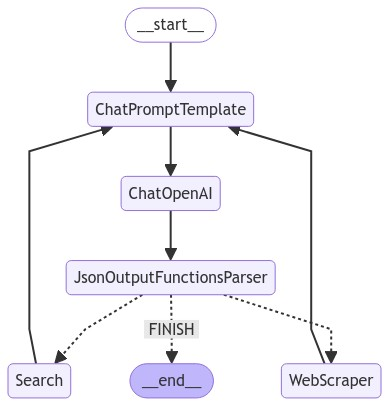

In [10]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

In [11]:
for s in research_chain.stream(
    "what is minhas vantagens?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Search'}}
---
{'Search': {'messages': [HumanMessage(content='I apologize, but the search results provided do not seem to be relevant to the query "minhas vantagens" (my advantages). It appears there may have been a misunderstanding or a lack of relevant documents in the database. If you\'re looking for information on personal advantages or benefits in a specific context, please provide more details or clarify your query so I can assist you more effectively.', name='Search')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


In [12]:
doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    "You are an expert writing a research document.\n"
    # The {current_files} value is populated automatically by the graph state
    "Below are files currently in your directory:\n{current_files}",
)
# Injects current directory working state before each call
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_agent(
    llm,
    [create_outline, read_document],
    "You are an expert senior researcher tasked with writing a paper outline and"
    " taking notes to craft a perfect paper.{current_files}",
)
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

#chart_generating_agent = create_agent(
#    llm,
#    [read_document, python_repl],
#    "You are a data viz expert tasked with generating charts for a research project."
#    "{current_files}",
#)
#context_aware_chart_generating_agent = prelude | chart_generating_agent
#chart_generating_node = functools.partial(
#    agent_node, agent=context_aware_note_taking_agent, name="ChartGenerator"
#)

doc_writing_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

In [13]:
# Create the graph here:
# Note that we have unrolled the loop for the sake of this doc
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

# Add the edges that always occur
authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")

# Add the edges where routing applies
authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "FINISH": END,
    },
)

authoring_graph.add_edge(START, "supervisor")
chain = authoring_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results


# We reuse the enter/exit functions to wrap the graph
authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

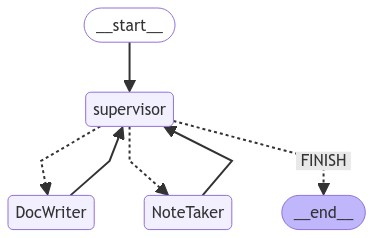

In [14]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

In [15]:
for s in authoring_chain.stream(
    "Write an outline for poem and then write the poem to disk.",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'NoteTaker'}}
---
{'NoteTaker': {'messages': [HumanMessage(content='The outline for the poem "Whispers of the Heart" has been saved to disk, and the poem itself has been written to disk as well. The outline and the poem are now ready for further review or publication.', name='NoteTaker')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


In [21]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4-1106-preview")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status."
    " You need to ensure that the content is not incomplete, if it is incomplete,"
    " demand the content you think is necessary from the responsible agents,"
    " after each iteration you need to concatenate all the content in a concise way."
    "When finished, respond with FINISH.",
    ["ResearchTeam", "PaperWritingTeam"],
)

In [22]:
# Define the graph.
super_graph = StateGraph(State)
# First add the nodes, which will do the work
super_graph.add_node("ResearchTeam", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "PaperWritingTeam", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

# Define the graph connections, which controls how the logic
# propagates through the program
super_graph.add_edge("ResearchTeam", "supervisor")
super_graph.add_edge("PaperWritingTeam", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "PaperWritingTeam": "PaperWritingTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)
super_graph.add_edge(START, "supervisor")
super_graph = super_graph.compile()

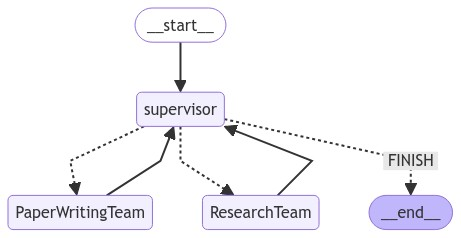

In [23]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [24]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Write an essay talking about why the sky is blue"
            )
        ],
    },
    {"recursion_limit": 150},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'ResearchTeam'}}
---
{'ResearchTeam': {'messages': [HumanMessage(content="Title: The Azure Canopy: Understanding Why the Sky is Blue\n\nThe sky's signature blue hue, a canvas that has inspired poets and puzzled scientists, is a phenomenon that is both simple and complex. It is a marvel of light and atmosphere that has fascinated humanity for millennia. In this essay, we will explore the scientific explanation behind the blueness of the sky, delving into concepts of light, atmospheric physics, and human perception.\n\nAt the heart of the sky's color lies the nature of sunlight and the atmosphere. Sunlight, often perceived as white or yellow, is a mixture of all colors of the visible spectrum. As this light makes its way through the Earth's atmosphere, it encounters air molecules, water droplets, and particulate matter. This is where the magic begins.\n\nThe scientific principle that explains the sky's color is known as Rayleigh scattering, named after the British